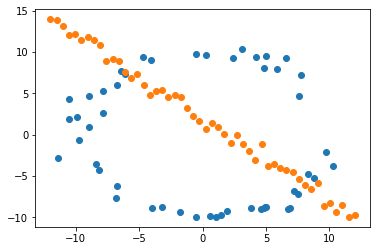

In [1]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
# np . random . seed ( 0 )
N = 100
half_n = N//2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )
#print(t)
#plt.scatter(x,y)
plt.scatter(X_circ[:,0],X_circ[:,1])
plt.scatter(X_line[:,0],X_line[:,1])

In [2]:
#Ransac Implementation
import numpy as np
import math

class RansacModel:

    
    def __init__(self, curve_fitting_model):
        self.curve_fitting_model = curve_fitting_model
    
    def fit(self, A, Y, num_sample, threshold):

        num_iterations = math.inf
        iterations_done = 0
        num_sample = 3

        max_inlier_count = 0
        best_model = None

        prob_outlier = 0.5
        desired_prob = 0.95

        total_data = np.column_stack((A, Y))  ## [ A | Y]
        data_size = len(total_data)

        # Adaptively determining the number of iterations
        while num_iterations > iterations_done:

            # shuffle the rows and take the first 'num_sample' rows as sample data
            np.random.shuffle(total_data)
            sample_data = total_data[:num_sample, :]
            
            estimated_model = self.curve_fitting_model.fit(sample_data[:,:-1], sample_data[:, -1:]) ## [a b c]

            # count the inliers within the threshold
            y_cap = A.dot(estimated_model)
            err = np.abs(Y - y_cap.T)
            inlier_count = np.count_nonzero(err < threshold)

            # check for the best model 
            if inlier_count > max_inlier_count:
                max_inlier_count = inlier_count
                best_model = estimated_model


            prob_outlier = 1 - inlier_count/data_size
            print('# inliers:', inlier_count)
            print('# prob_outlier:', prob_outlier)
            num_iterations = math.log(1 - desired_prob)/math.log(1 - (1 - prob_outlier)**num_sample)
            iterations_done = iterations_done + 1

            print('# s:', iterations_done)
            print('# n:', num_iterations)
            print('# max_inlier_count: ', max_inlier_count)

        return best_model

In [32]:
R_model=RansacModel(X_circ.flatten())
best_mpdel=R_model.fit(x,y,15,1)
#print(best_mpdel)

AttributeError: 'list' object has no attribute 'fit'

In [31]:
#np.shape(X_circ.flatten())
np.shape([X_circ.flatten()])


(1, 100)

In [24]:
def direct_least_square(x, y):
    D = np.mat(np.vstack([x**2, x*y, y**2, x, y, np.ones(len(x))])).T
    S = np.dot(D.T, D)
    C = np.zeros((6, 6))
    C[0, 2] = 2
    C[1, 1] = -1
    C[2, 0] = 2
    Z = np.dot(np.linalg.inv(S), C)
    eigen_value, eigen_vec = np.linalg.eig(Z)
    eigen_value = eigen_value.reshape(1, -1)
    pos_r, pos_c = np.where(eigen_value>0 & ~np.isinf(eigen_value))
    a = eigen_vec[:, pos_c]
    return a
import random 
def ransac(image, max_iter, threshold=5):
    ellipse_noise = image
    data = ellipse_noise
    ics = []
    best_ic = 0
    best_model = None
    xn, yn = data.nonzero()
    nzero = [(x1,y1) for x1, y1 in zip(xn, yn)]
    for epoch in range(max_iter):
        ic = 0
        sample = random.sample(nzero, 6)
        a = direct_least_square(np.array([s[0] for s in sample]), np.array([s[1] for s in sample]))
        for x, y in sample:
            eq = np.mat(np.vstack([x**2, x*y, y**2, x, y, 1])).T
            if np.abs(np.dot(eq, a.reshape(-1,1))) <= threshold:
                ic += 1
        ics.append(ic)
        if ic > best_ic:
            best_ic = ic
            best_model = a
    return a, ics
a, _ = ransac(X_circ[:], 500, 5)

LinAlgError: Singular matrix

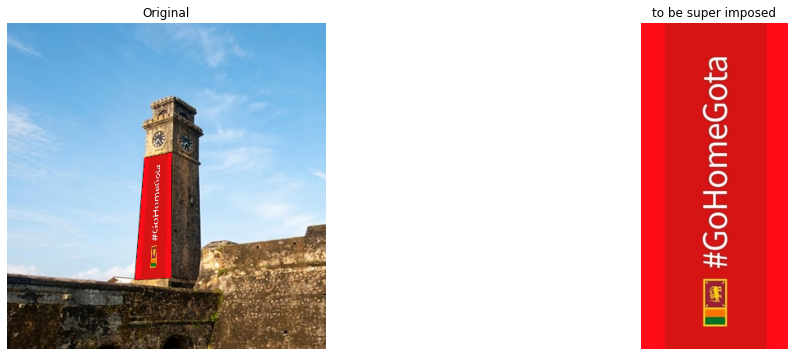

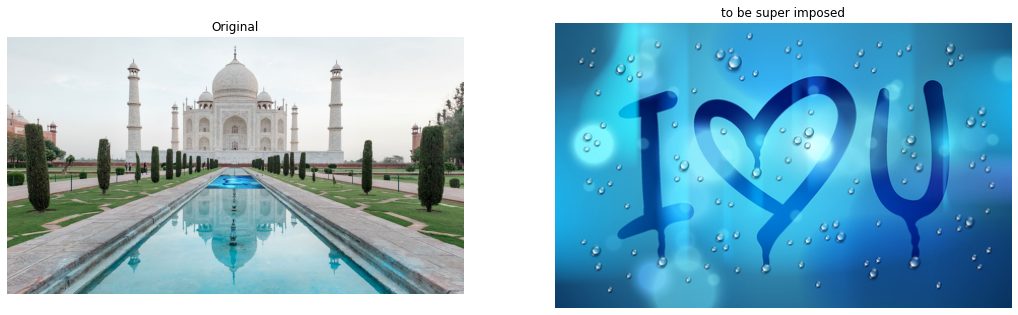

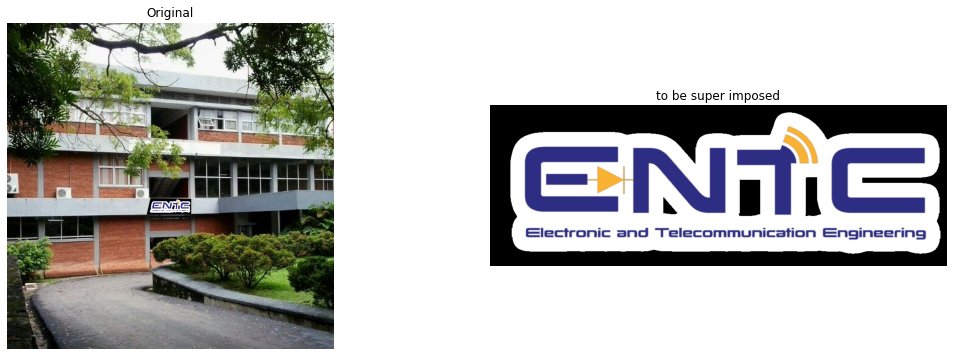

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def mouse_handler(event, x, y, flags, data) :
    
    if event == cv.EVENT_LBUTTONDOWN :
        cv.circle(data['im'], (x,y),3, (0,0,255), 5, 16)
        cv.imshow("Image", data['im'])
        if len(data['points']) < 4 :
            data['points'].append([x,y])

def get_four_points(im):
    
    # Set up data to send to mouse handler
    data = {}
    data['im'] = im.copy()
    data['points'] = []
    
    #Set the callback function for any mouse event
    cv.imshow("Image",im)
    cv.setMouseCallback("Image", mouse_handler, data)
    cv.waitKey(0)
    
    # Convert array to np.array
    points = np.vstack(data['points']).astype(float)
    
    return points

image = [('Images/Go_Home_Gota.jpg',"Images/Galle_Fort.jpg"),("Images/I_Love_You.jpg","Images/Taj_Mahal.jpg"),("Images/ENTC.png","Images/Civil_Department.jpg")]
for (src, dst) in image:    
    # Read source image.
    im_src = cv.imread(src)
    cv.rotate(im_src,cv.cv2.ROTATE_90_COUNTERCLOCKWISE)
    size = im_src.shape

    # Create a vector of source points.
    pts_src = np.array(
                    [
                        [0,0],
                        [size[1] - 1, 0],
                        [size[1] - 1, size[0] -1],
                        [0, size[0] - 1 ]
                        ],dtype=float
                        )

    # Read destination image
    im_dst = cv.imread(dst)

    # Get four corners of the billboard
    pts_dst = get_four_points(im_dst)

    # Calculate Homography between source and destination points
    h, status = cv.findHomography(pts_src, pts_dst)

    # Warp source image
    im_temp = cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

    # Black out polygonal area in destination image.
    cv.fillConvexPoly(im_dst, pts_dst.astype(int), 0, 16)

    # Add warped source image to destination image.
    im_dst = im_dst + im_temp

    # Display image.
    cv.namedWindow("Image")
    cv.imshow("Image", im_dst)
    cv.waitKey(0)
    cv.destroyAllWindows()

    f,ax=plt.subplots(1,2,figsize=(18,6))                    
    ax[0].imshow(cv.cvtColor(im_dst,cv.COLOR_BGR2RGB))
    ax[0].set_title("Original")
    ax[0].axis('off')
    ax[1].imshow(cv.cvtColor(im_src, cv.COLOR_BGR2RGB))
    ax[1].set_title("to be super imposed")
    ax[1].axis('off')

    plt.show()